In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import math
from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d
from skimage import data
from skimage.filters import threshold_otsu

# Example 3D scan

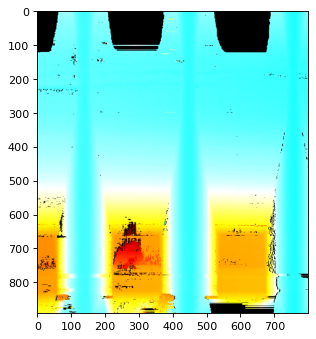

In [5]:
im = cv.imread(r'D:\Konrad\TCM_3D\20211102_114055_msa_type1_keyence_png\3D_S003_R002_211102_114346.png')
figure(figsize=(5, 5), dpi=80)
plt.imshow(im)

# Teeth 3D MSA analyze

In [3]:
def fz1(A,B,show = False):
    sx,sy = r.shape
    sum1 = np.zeros(shape=[sx, sy, 1], dtype=np.uint16)
    sumg = np.zeros(shape=[sx, sy, 1], dtype=np.uint16)
    sumd = np.zeros(shape=[sx, sy, 1], dtype=np.uint16)

    # Deletinf 0 - values (scanning holes)
    for x in range(600,sx):
        for y in range(500,750):

            if(r[x,y] == 255 or (b[x,y]) == 0 and g[x,y] == 0):
                sum1[x,y] = (int)(r[x,y]) + (int)(g[x,y]) + (int)(b[x,y])  
            else:
                sum1[x,y] = 6*255 - r[x,y] - g[x,y] - b[x,y]
                
            if(sum1[x,y] < A or sum1[x,y] > B): sum1[x,y] = 0

    # Finding treshold
    his = sum1[sum1 > 0]
    hist, bins = np.histogram(his, bins = B - A)
    freq = 300
    hist[np.where(hist <= freq)] = 0
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    hist0 = hist[hist > 0]
    srodek = int(len(hist0)/2)
    poczatek = np.where(hist == hist0[0])
    thresh = center[int(poczatek[0][0] + srodek)]
   
    # Applying treshold
    for x in range(600,sx):
        for y in range(500,750):
            if(sum1[x,y] < thresh and sum1[x,y] > thresh - 16): sumd[x,y] = sum1[x,y].copy()
            if(sum1[x,y] > thresh and sum1[x,y] < thresh + 16): sumg[x,y] = sum1[x,y].copy()   
    
    # Erosion - borders filtration
    kernel = np.ones((15, 15), np.uint8)
    sumd = cv.erode(sumd, kernel) 

    # Display
    fig, axes = plt.subplots(ncols=4, figsize=(15, 4))
    ax = axes.ravel()
    if( show == True): 
        ax[0] = plt.subplot(1, 4, 1)
        ax[0].imshow(sum1)
        ax[0].imshow(sum1) 
        ax[1] = plt.subplot(1, 4, 2)
        ax[1].hist(his,bins = B - A)    
        ax[1].axvline(thresh, color='r')
        ax[1].axvline(thresh - 16, color='g')
        ax[1].axvline(thresh + 16, color='g')
        ax[2] = plt.subplot(1, 4, 3)
        ax[2].imshow(sumg) 
        ax[3] = plt.subplot(1, 4, 4)
        ax[3].imshow(sumd)
        plt.show()  
    
    meang = np.mean(sumg[sumg > 0])
    meand = np.mean(sumd[sumd > 0])
    return (meang - meand) * 0.005

20211103_140850_pwr_b_odtwarzalnosc_1_ws


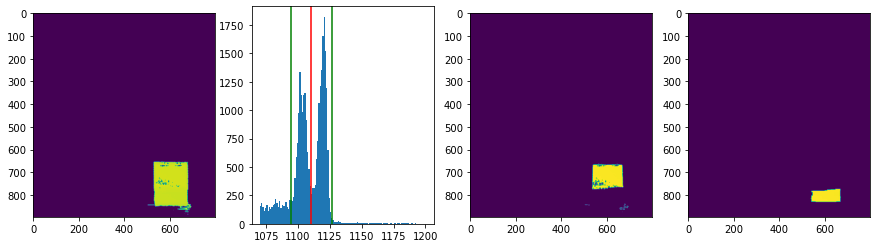

ws 002 0.09700459459018249


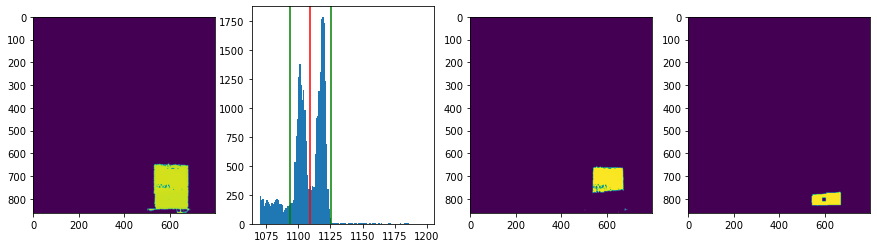

ws 003 0.09555289191055977


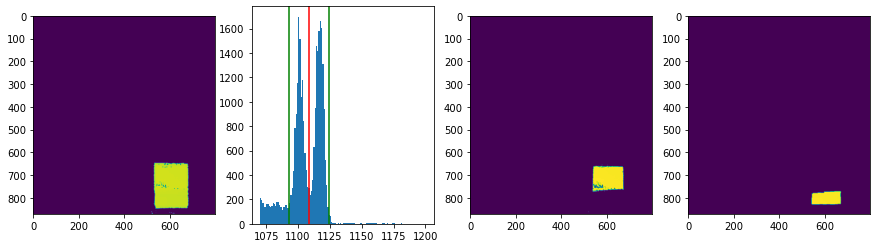

ws 004 0.09361356656293765


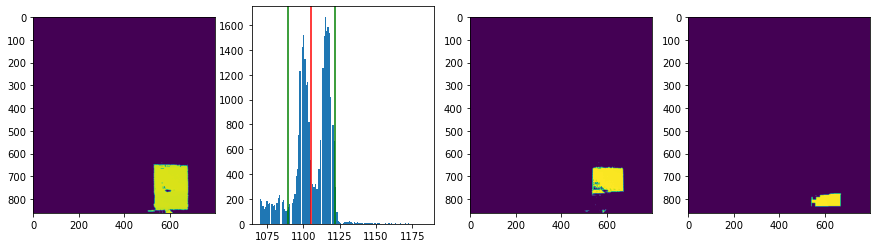

ws 005 0.09269593146419311


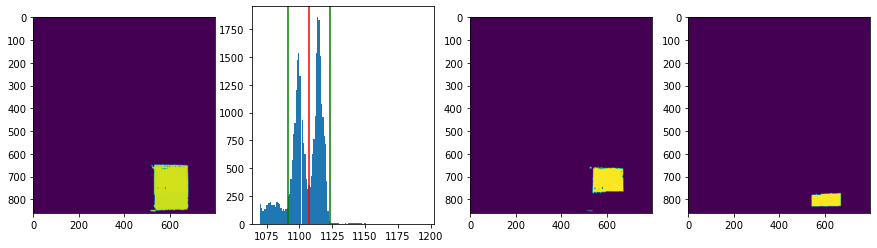

ws 006 0.09284440788895722


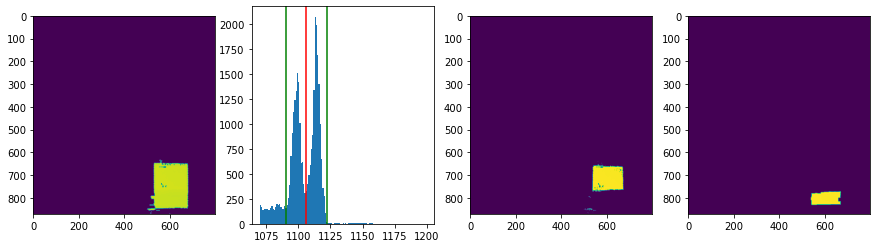

ws 007 0.0914148029560306


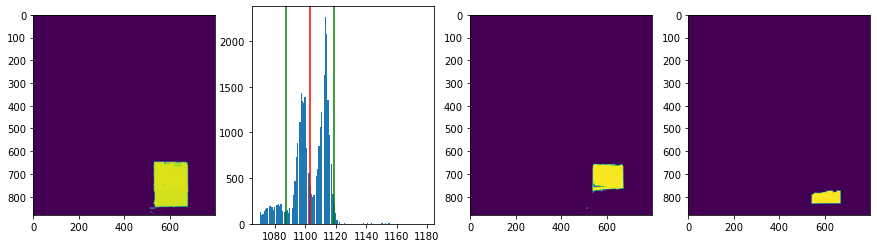

ws 008 0.0865728116255741


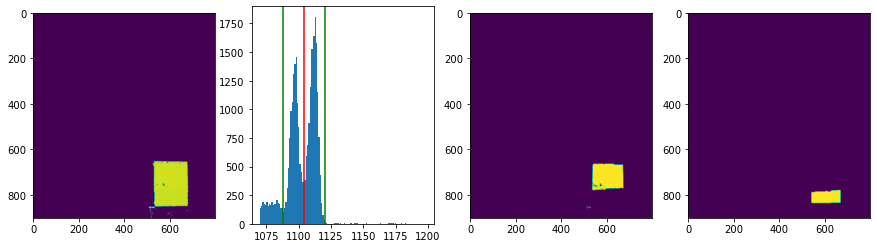

ws 009 0.08890118473809025


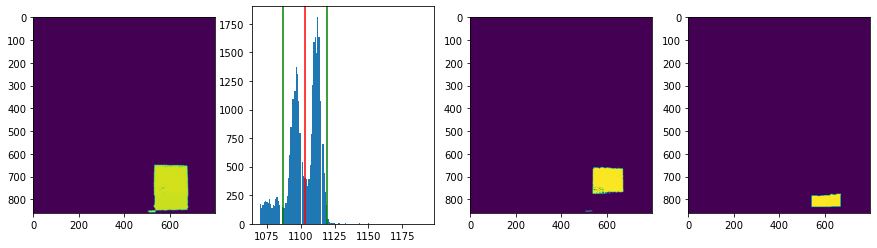

ws 010 0.092063088708735


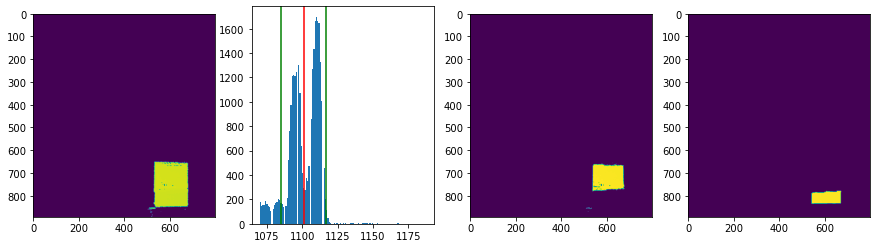

ws 011 0.08887155590812312


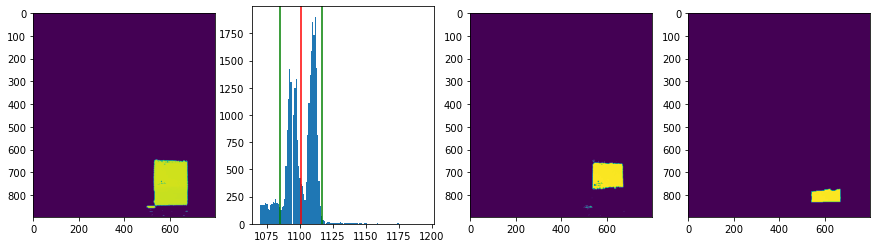

ws 012 0.09182332721640137


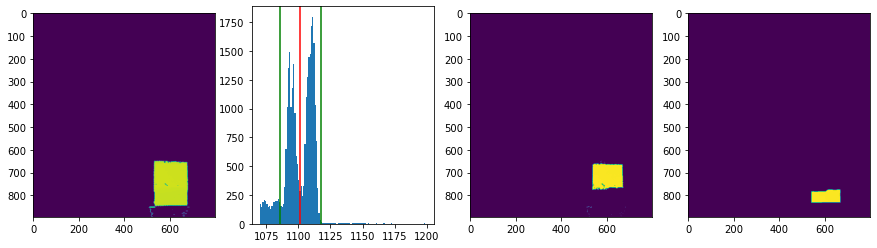

ws 013 0.090148860132025


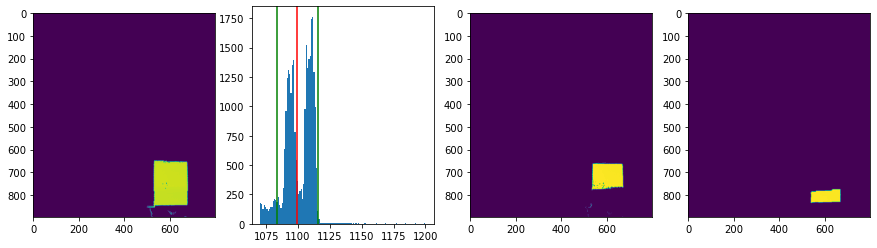

ws 014 0.09039391223998905


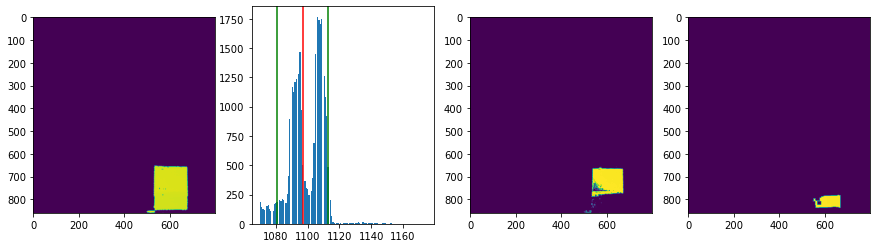

ws 015 0.08924319643825471


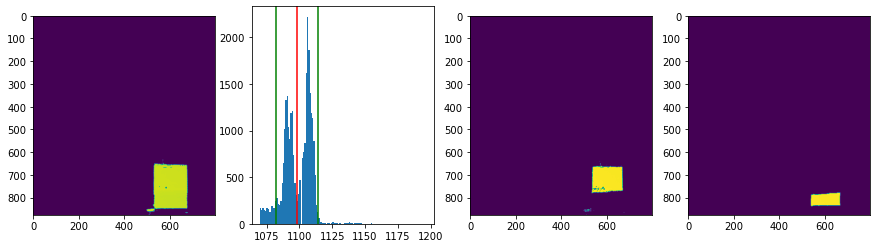

ws 016 0.08884009147838469


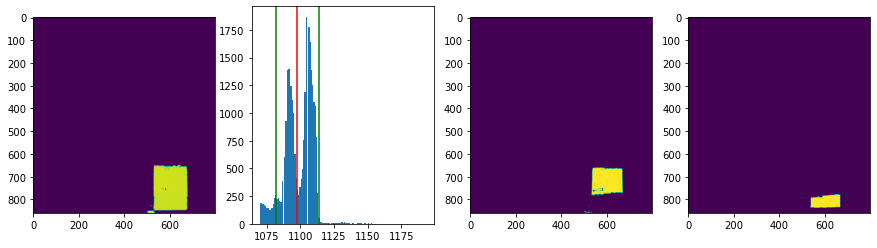

ws 017 0.08975609077778131


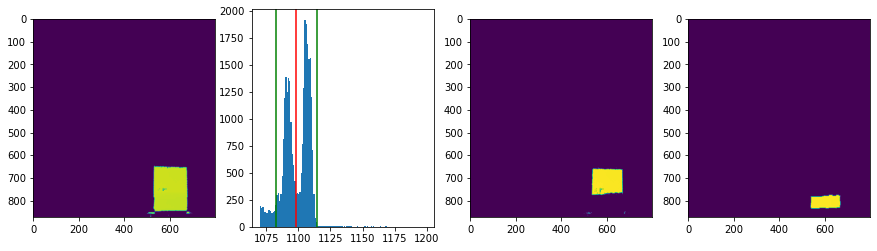

ws 018 0.08935343479139989


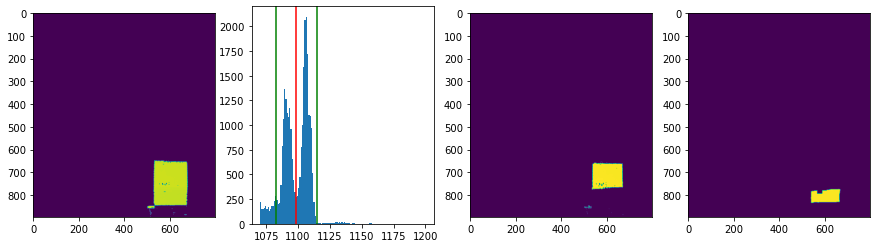

ws 019 0.09053522925800962


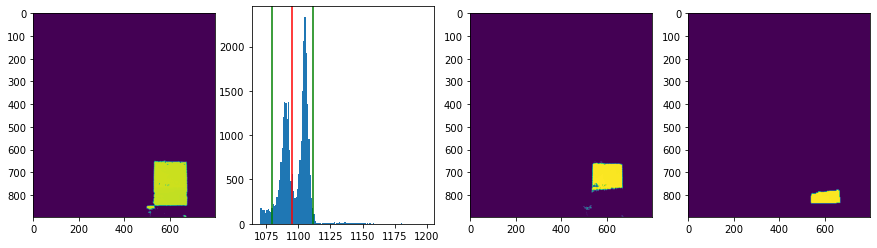

ws 020 0.08911675350560358


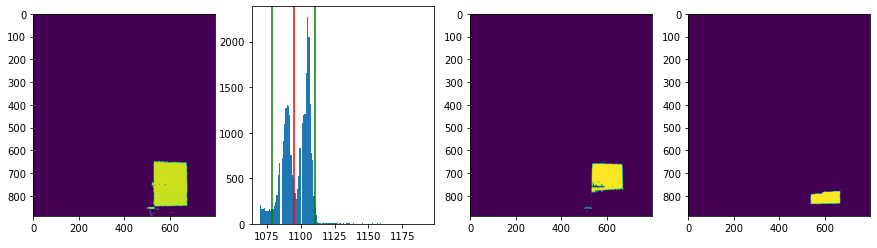

ws 021 0.09116541774471103


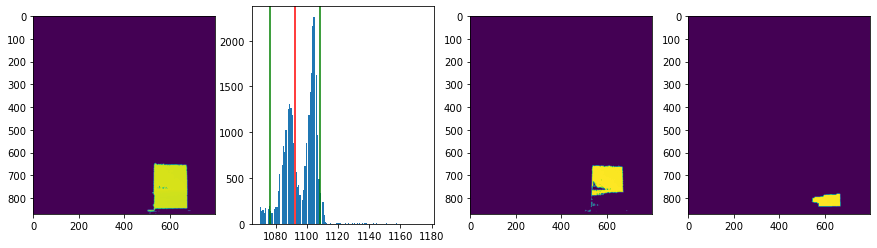

ws 022 0.09152240219910823


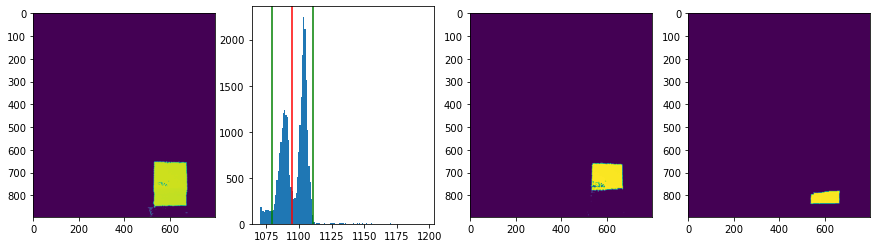

ws 023 0.0942394992567472


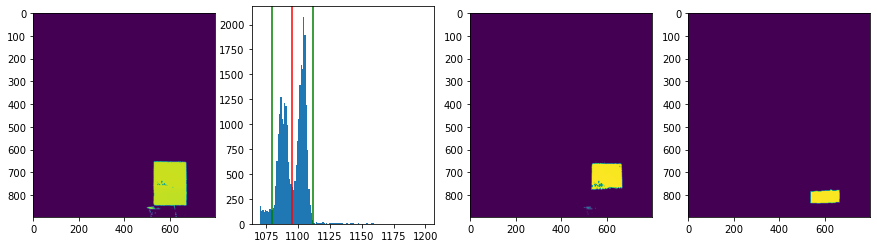

ws 024 0.09286902975987914


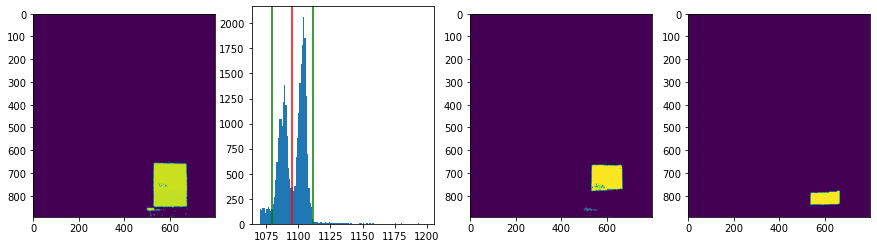

ws 025 0.09332285478034806


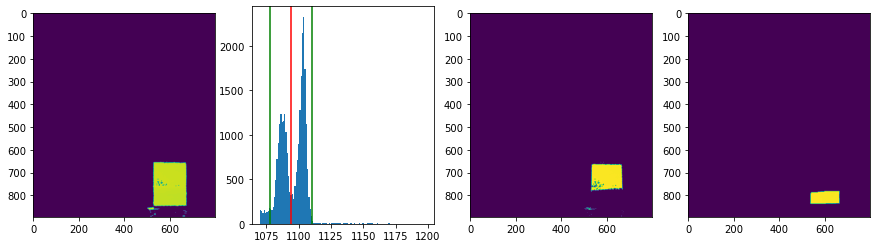

ws 026 0.09495408846101214


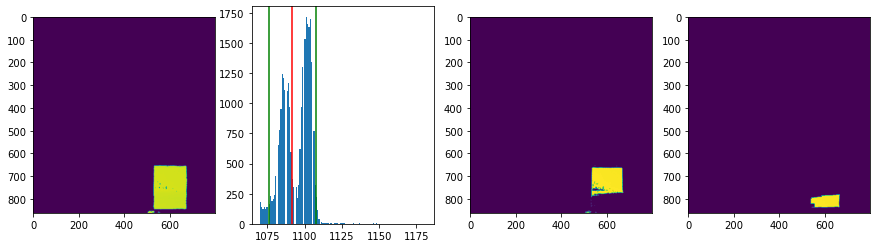

ws 027 0.09321789014260162


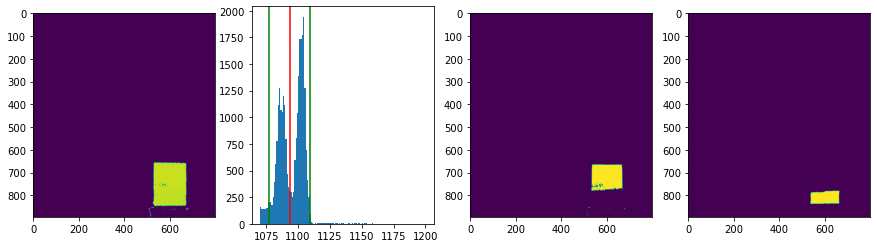

ws 028 0.09421456038826477


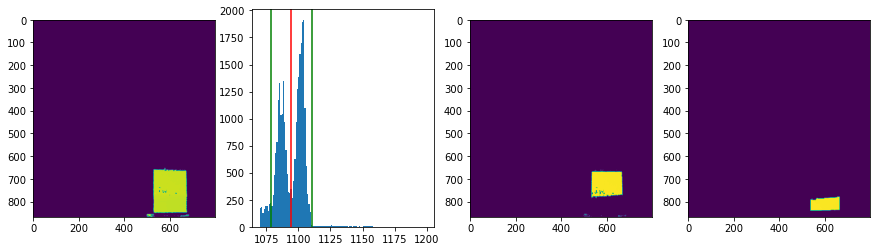

ws 029 0.093097484602755


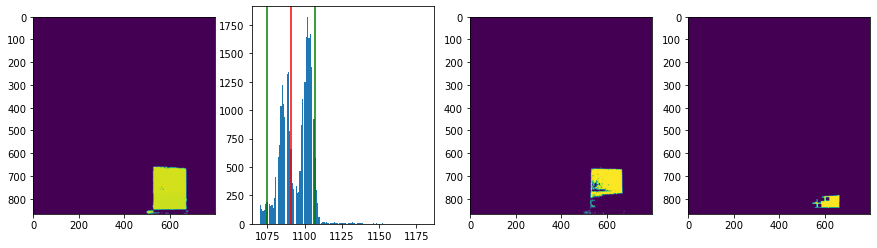

ws 030 0.09320659952201141
20211103_141830_pwr_b_odtwarzalnosc_2_ws


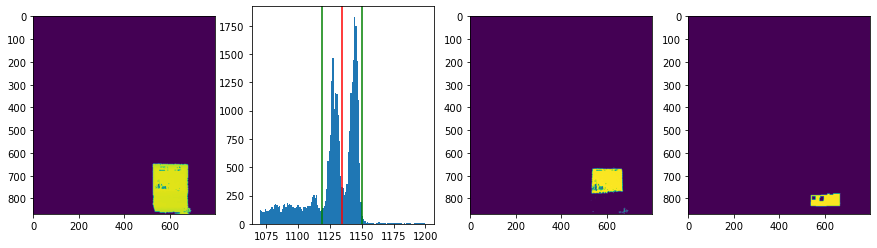

ws 002 0.09501624008238309


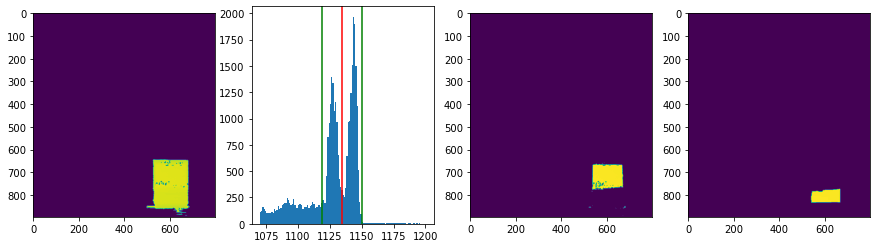

ws 003 0.09393455048396049


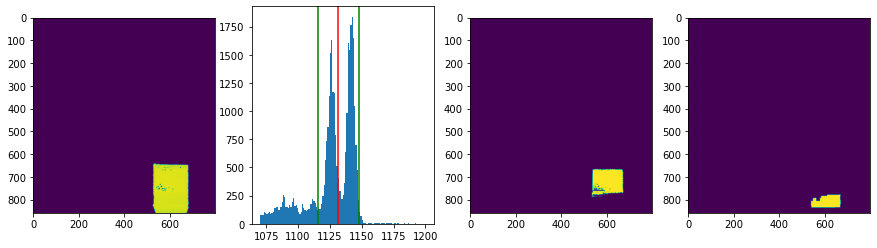

ws 004 0.09115555252154195


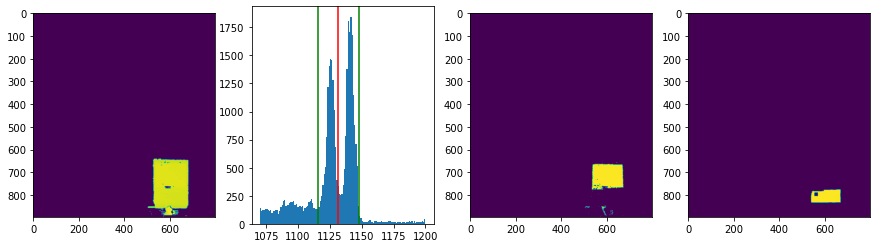

ws 005 0.09336753287670263


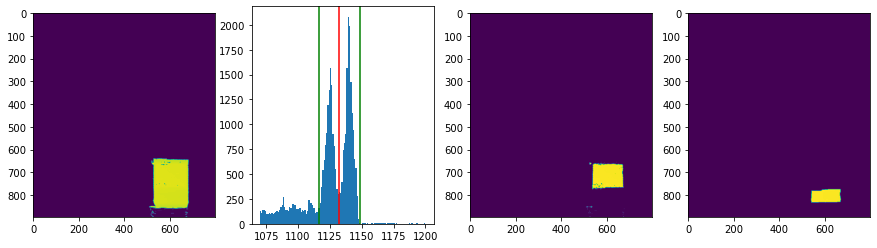

ws 006 0.09212174528282845


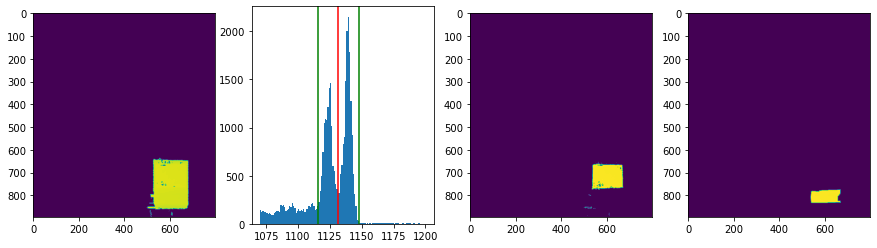

ws 007 0.09189736641944023


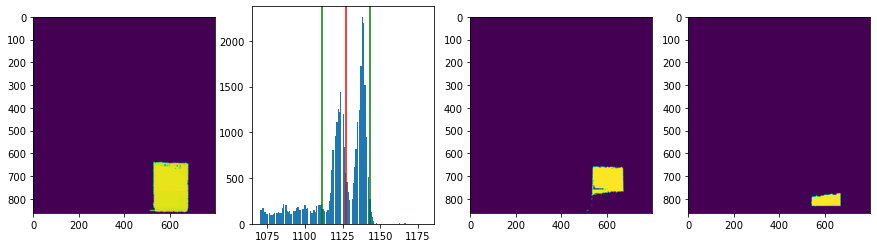

ws 008 0.0870800297835001


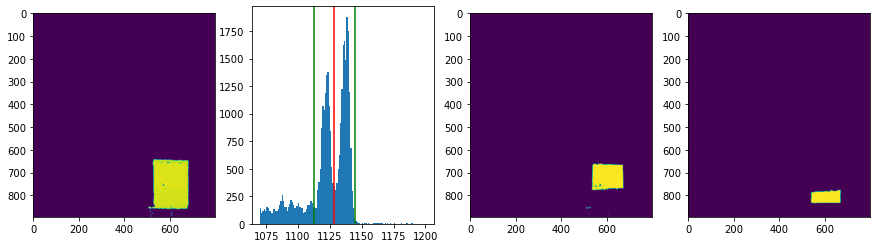

ws 009 0.09117188566562391


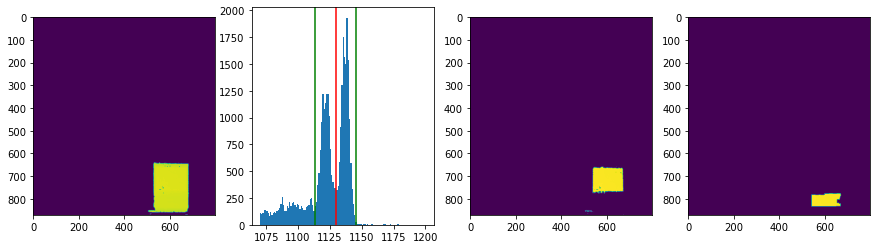

ws 010 0.09340290125714205


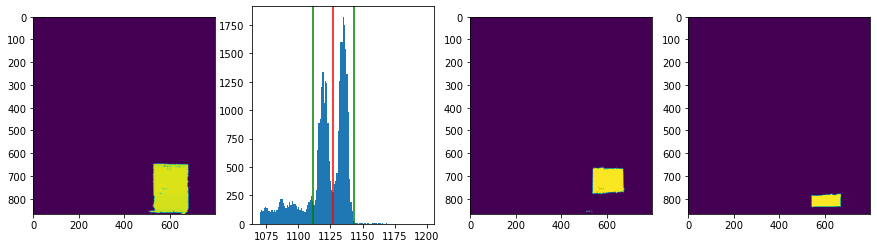

ws 011 0.0916762681799844


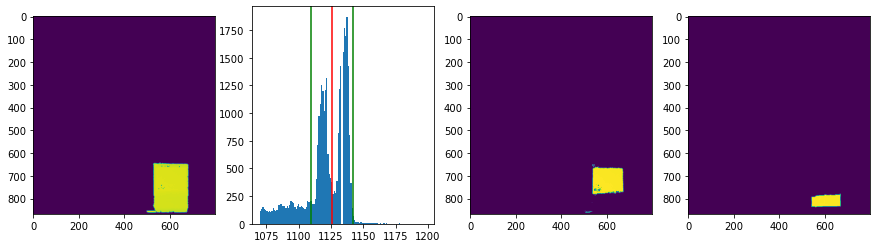

ws 012 0.0931777540767041


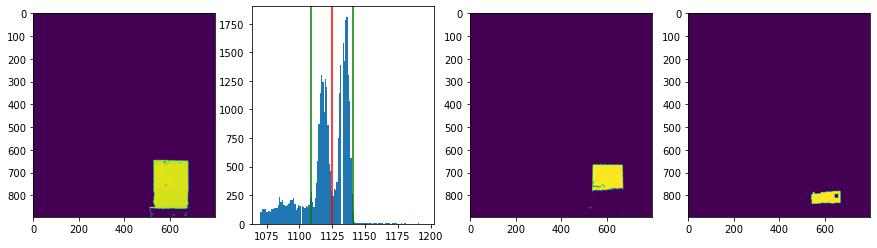

ws 013 0.09262349406005115


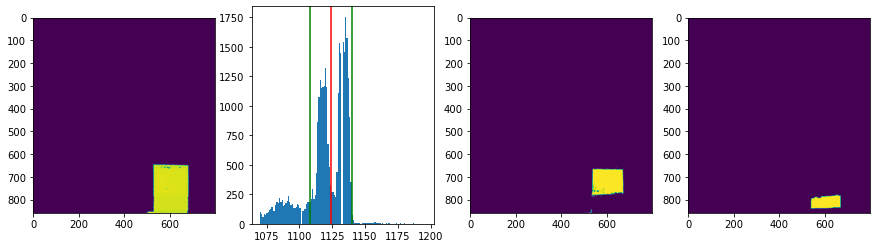

ws 014 0.09171124948586226


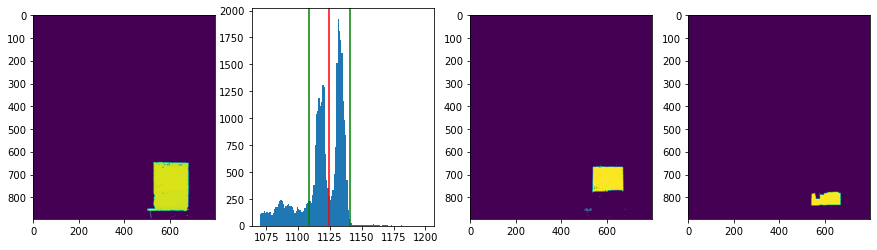

ws 015 0.09156530084643577


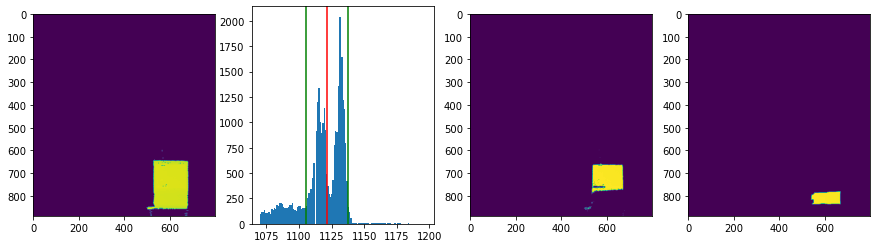

ws 016 0.09339533387296683


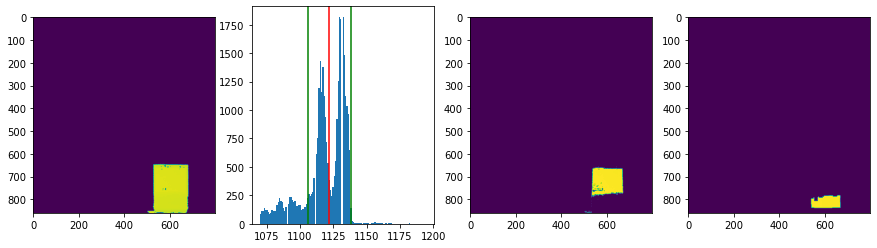

ws 017 0.0935134437608292


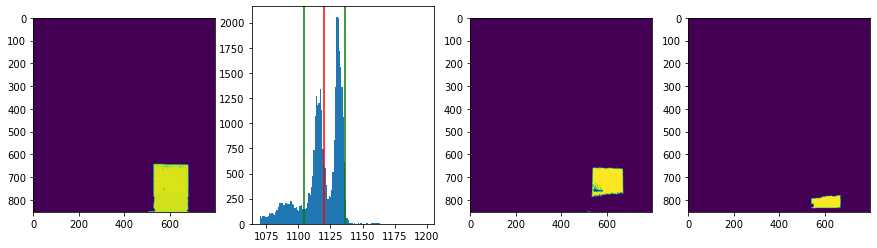

ws 018 0.09193664056845818


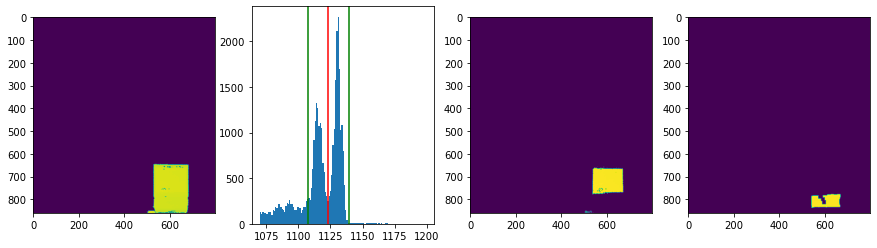

ws 019 0.09310707422040196


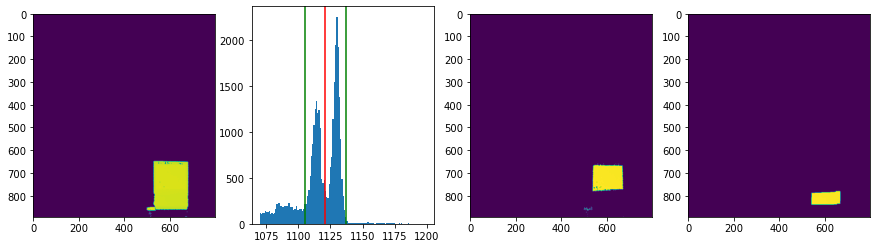

ws 020 0.09287985386829518


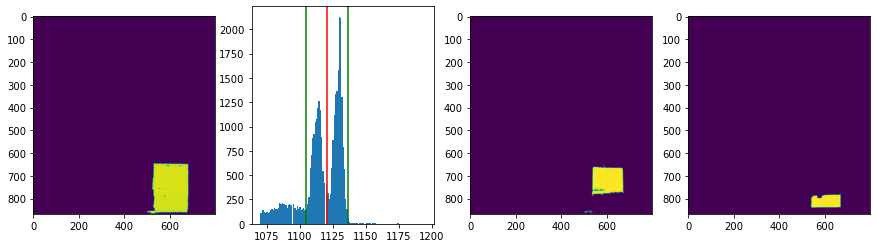

ws 021 0.09649765698301507


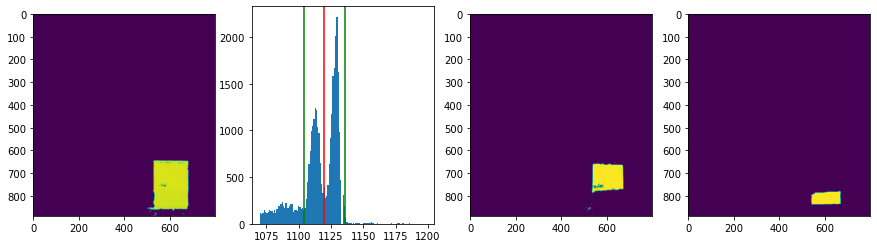

ws 022 0.09637072343597083


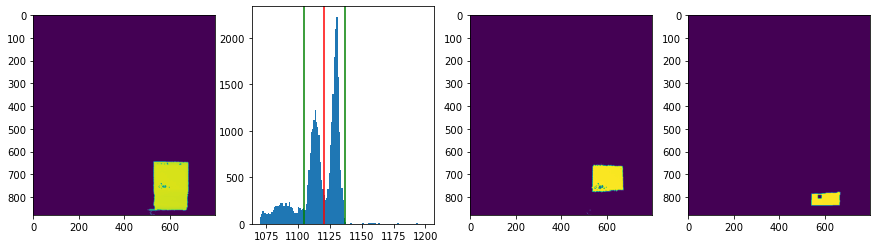

ws 023 0.09711368456698892


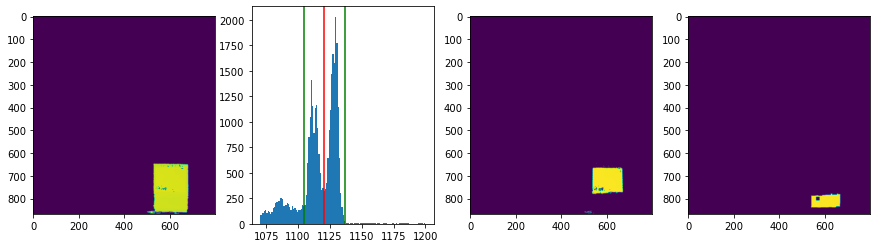

ws 024 0.09689360463588059


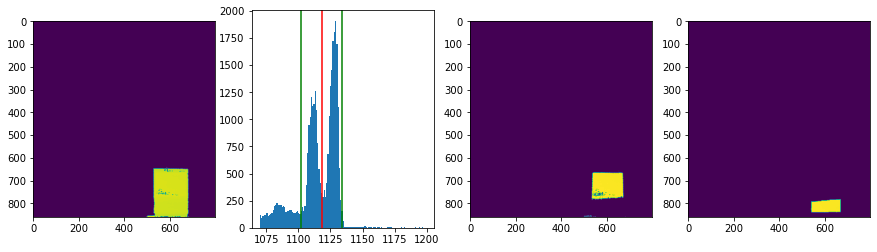

ws 025 0.09610111356557127


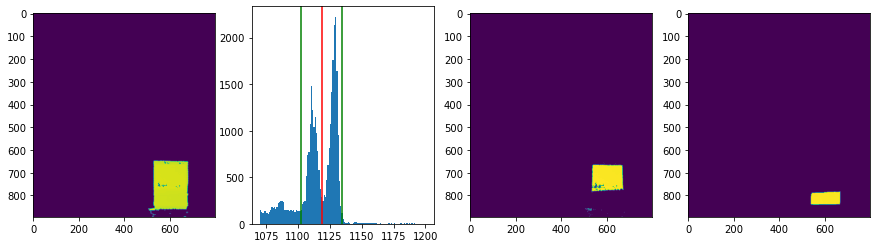

ws 026 0.09813417195657621


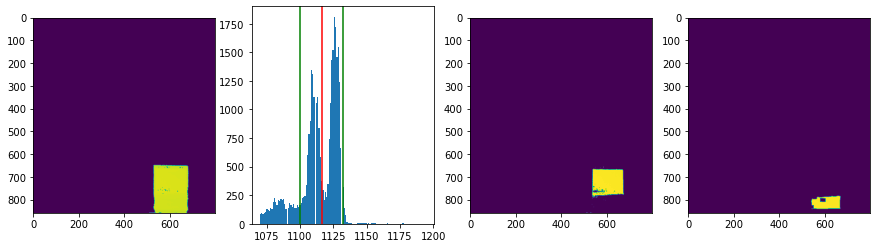

ws 027 0.09554585997477716


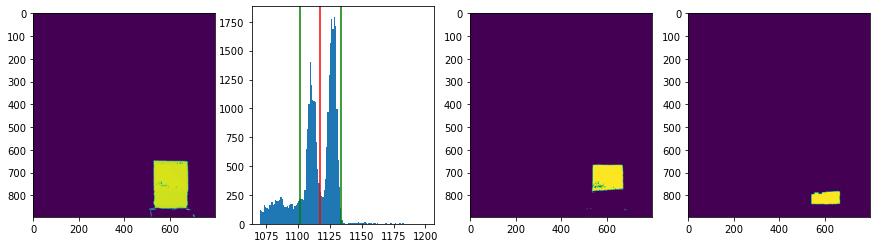

ws 028 0.09689855188434081


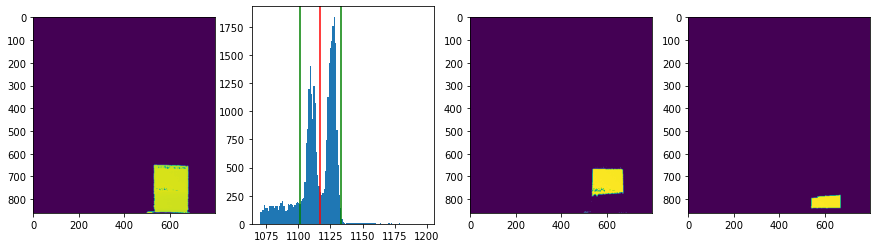

ws 029 0.09525372943053981


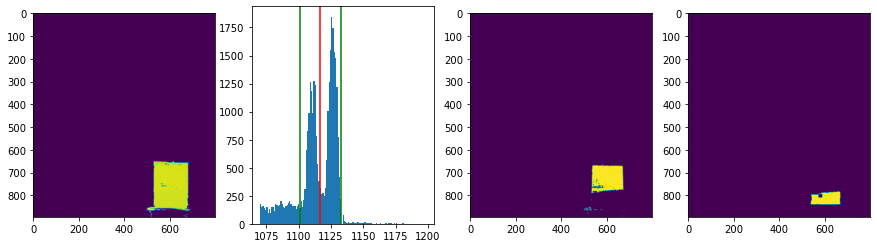

ws 030 0.09612607079153578
20211103_143553_pwr_b_odtwarzalnosc_3_mc


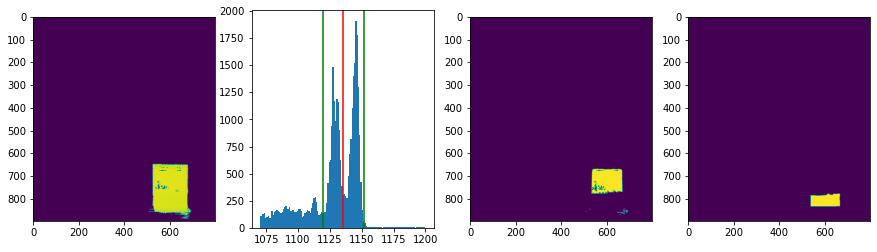

mc 002 0.09550152628938349


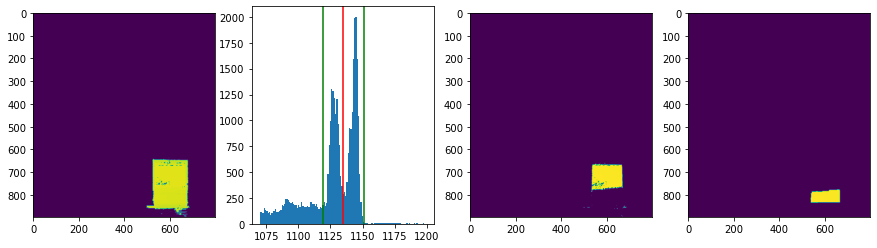

mc 003 0.09361485920408882


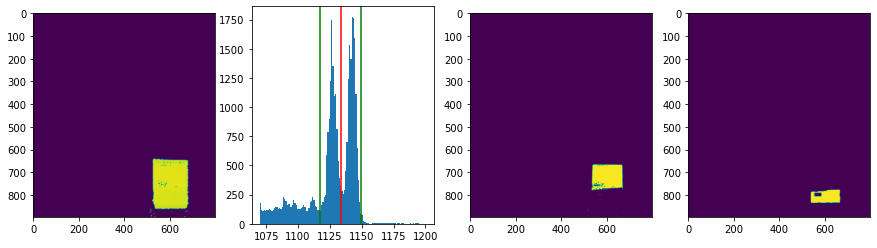

mc 004 0.09118868402668114


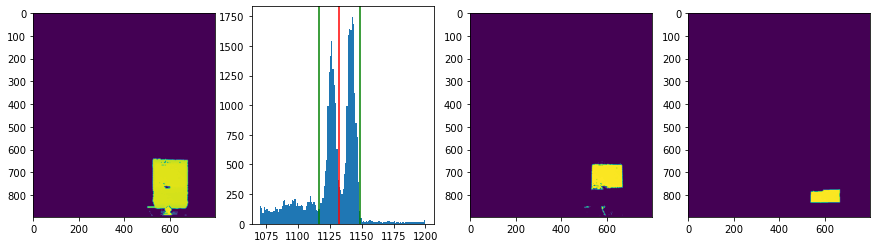

mc 005 0.09248281392925264


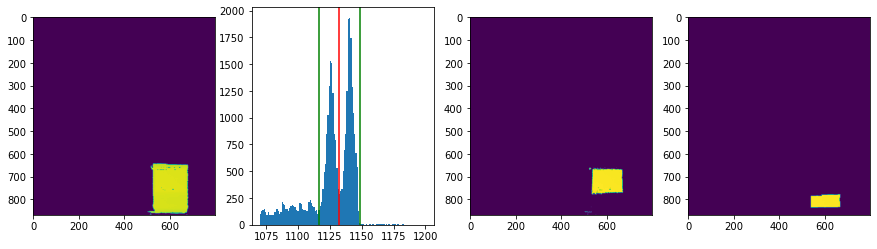

mc 006 0.09091483982728164


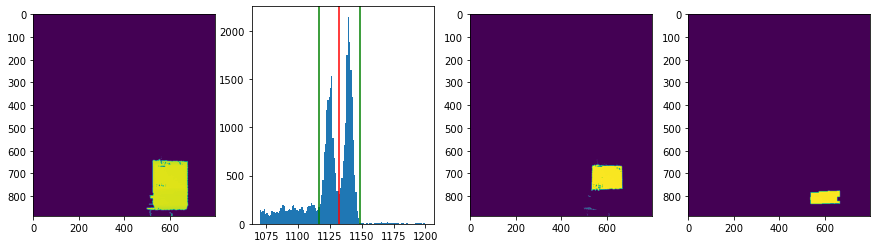

mc 007 0.09060089678927512


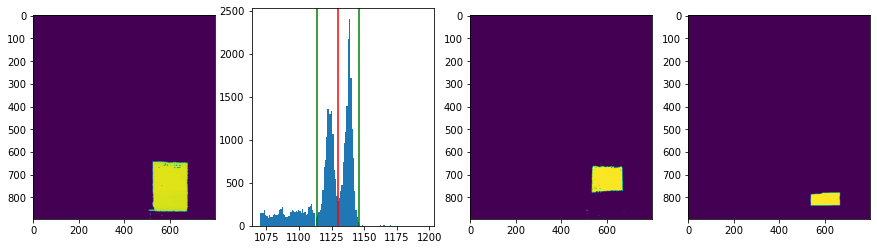

mc 008 0.08774554255048883


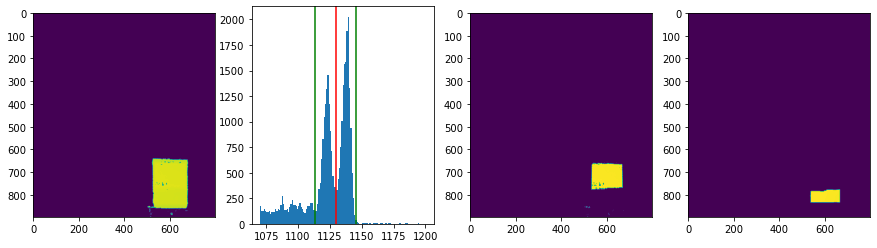

mc 009 0.09023640503894399


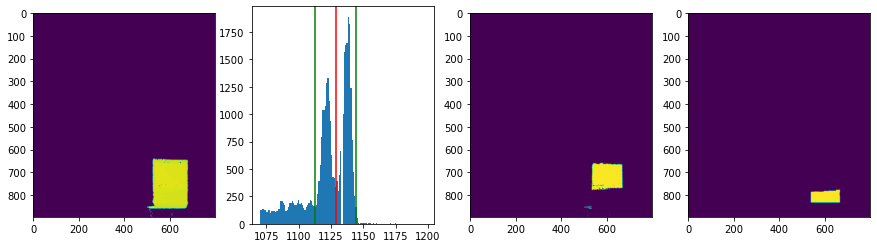

mc 010 0.09240157564809011


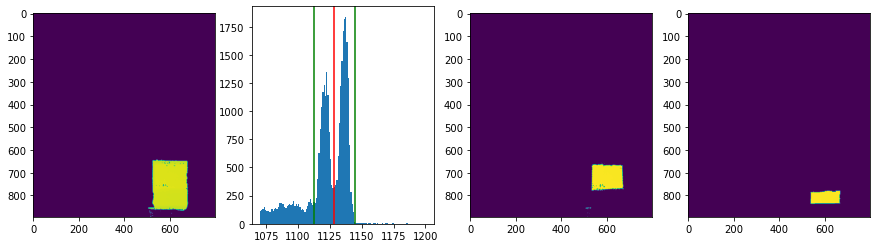

mc 011 0.09153155291718576


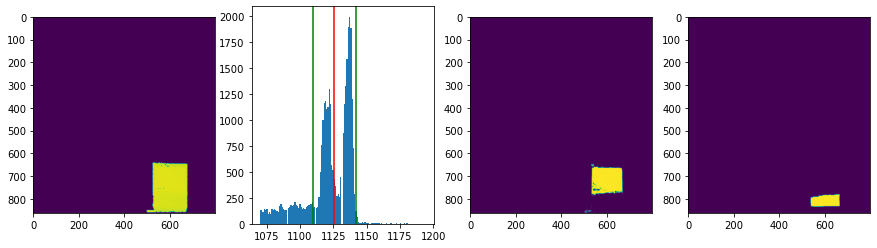

mc 012 0.09250495533165691


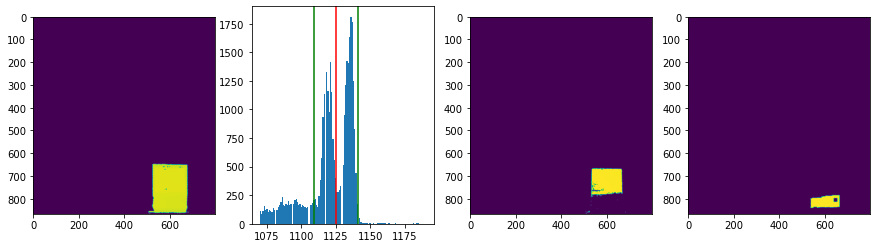

mc 013 0.09069006470699378


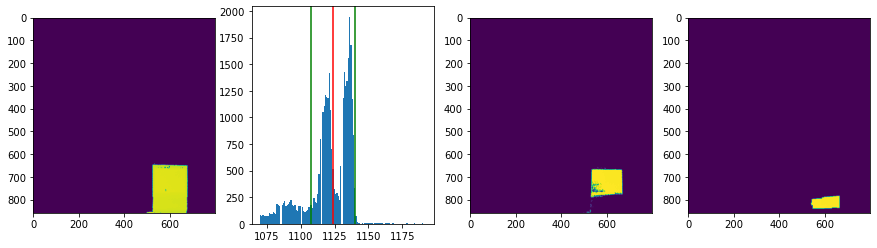

mc 014 0.09029183002947434


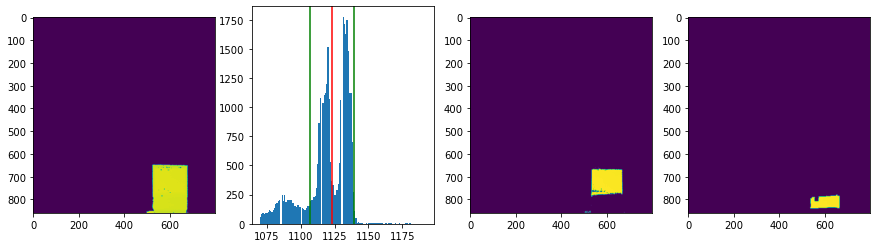

mc 015 0.09075618893784053


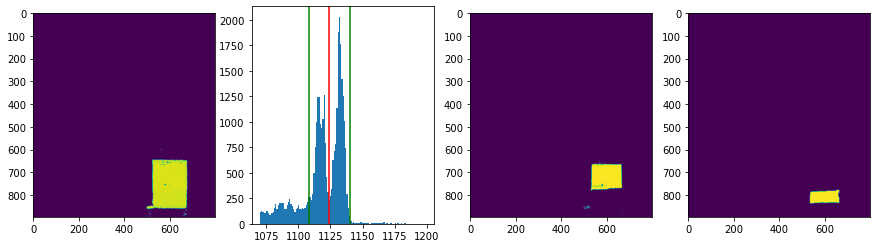

mc 016 0.09220299645986871


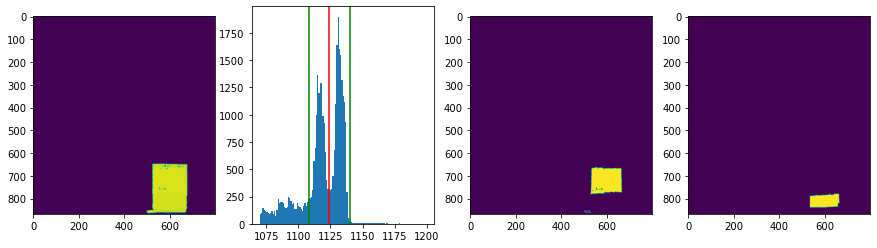

mc 017 0.09243309541388157


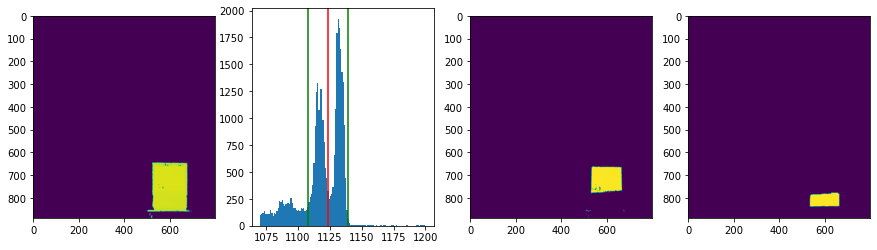

mc 018 0.0929765855826554


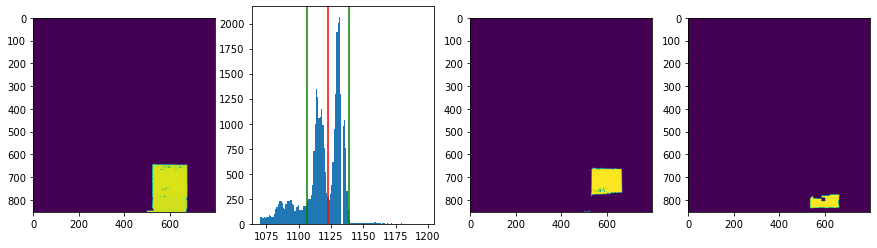

mc 019 0.09321330990787374


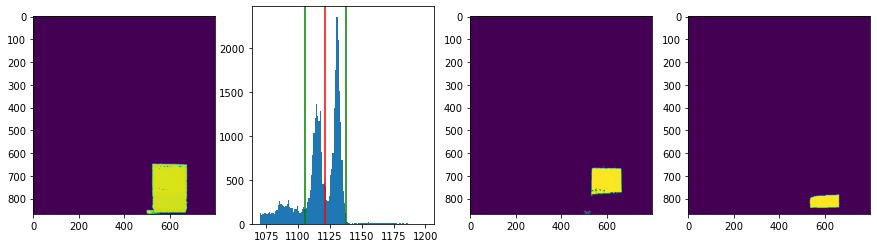

mc 020 0.09366731842288233


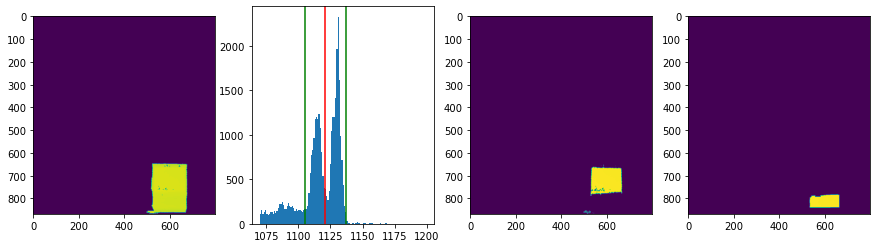

mc 021 0.0957165012391215


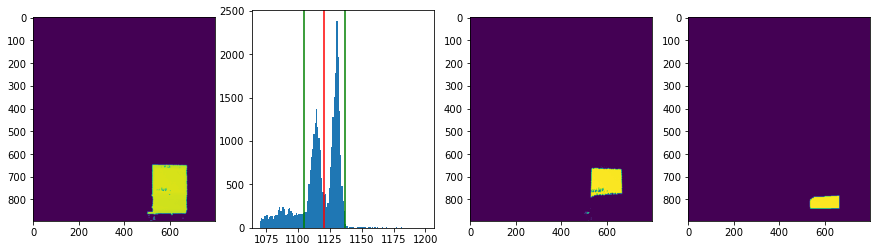

mc 022 0.09663820066823632


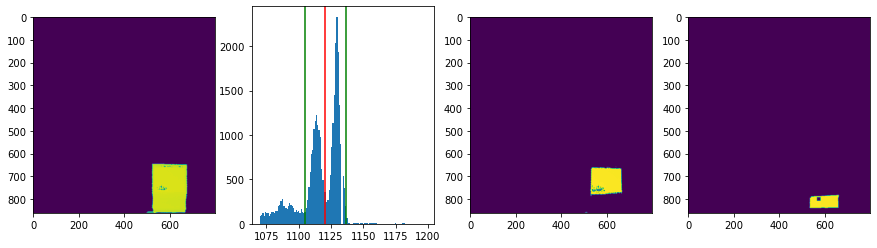

mc 023 0.09544837654344292


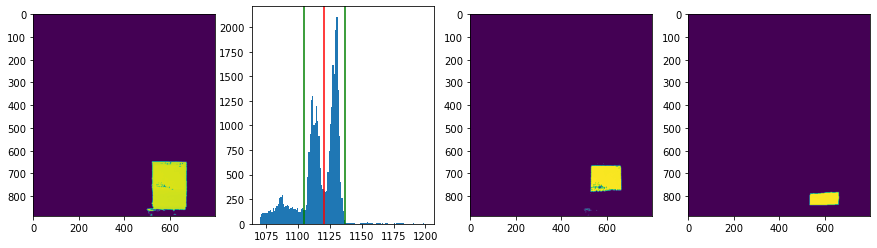

mc 024 0.09665948634763026


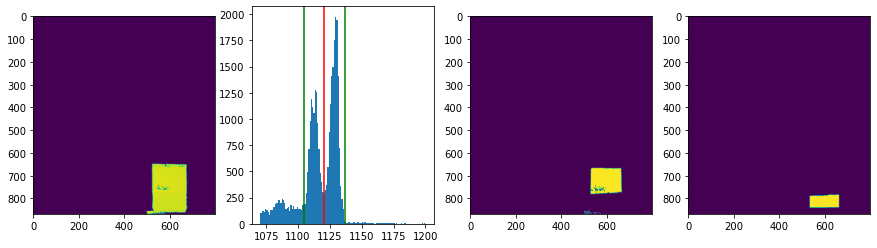

mc 025 0.09585913109374246


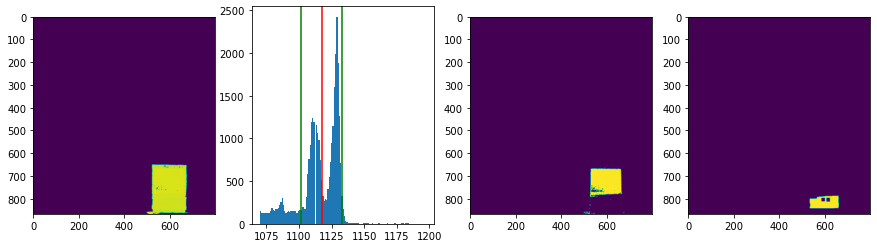

mc 026 0.09492721452726528


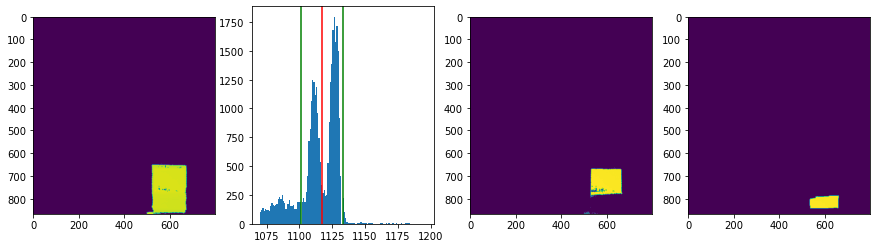

mc 027 0.09552179705233357


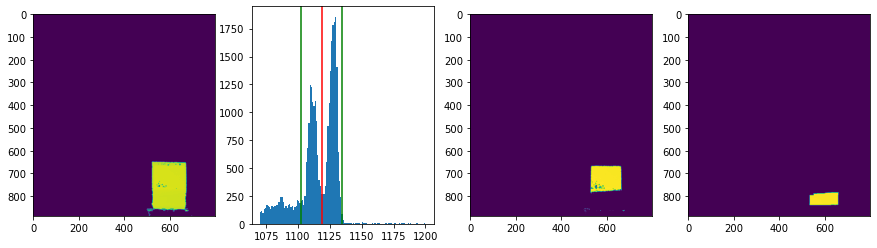

mc 028 0.09664104711654545


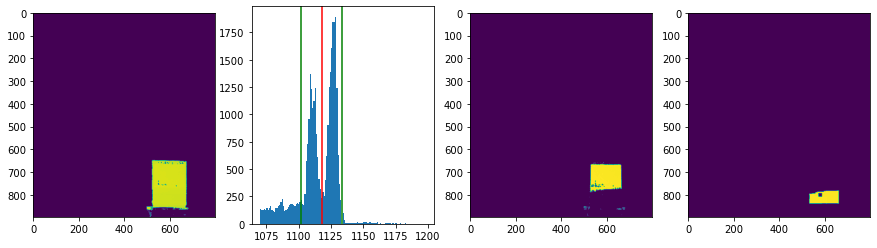

mc 029 0.09492979960397747


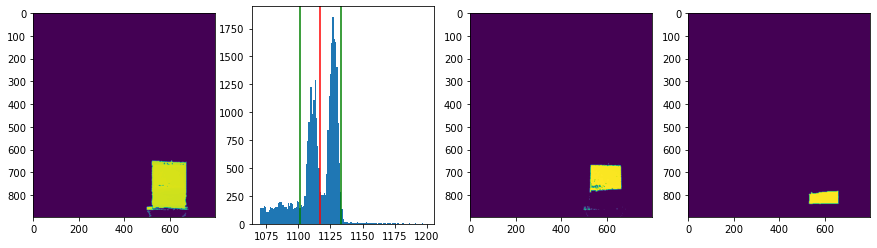

mc 030 0.09633977545465655
20211103_145057_pwr_b_odtwarzalnosc_4_mc


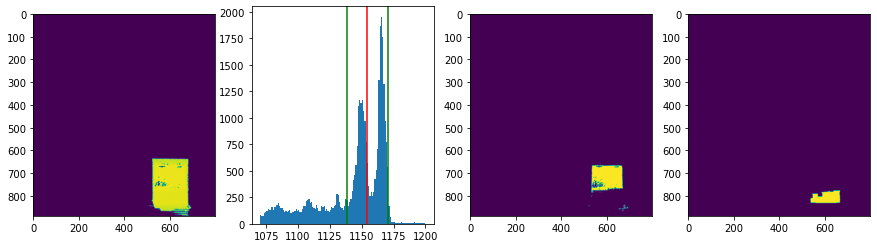

mc 002 0.09827329523545927


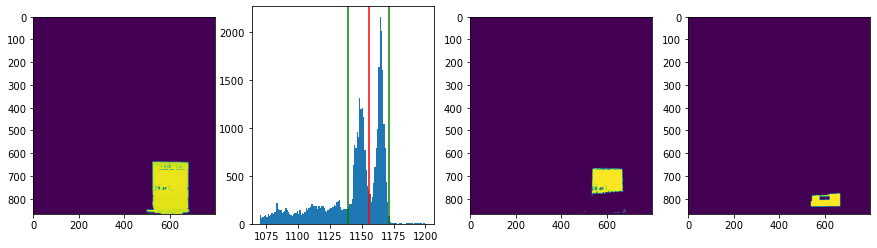

mc 003 0.09580759904943761


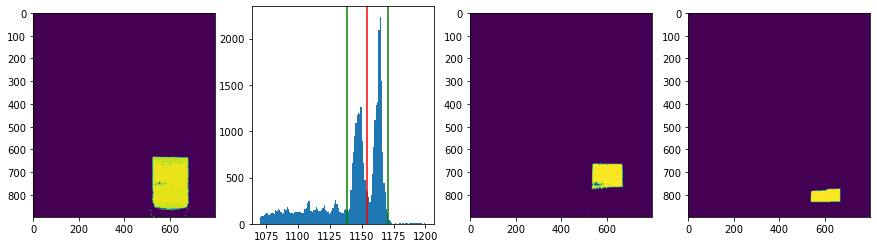

mc 004 0.09579554336920751


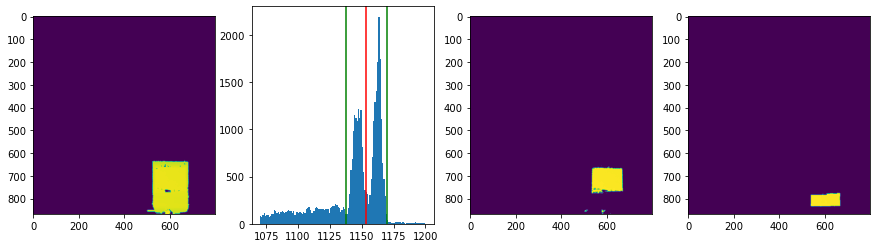

mc 005 0.09599486479110624


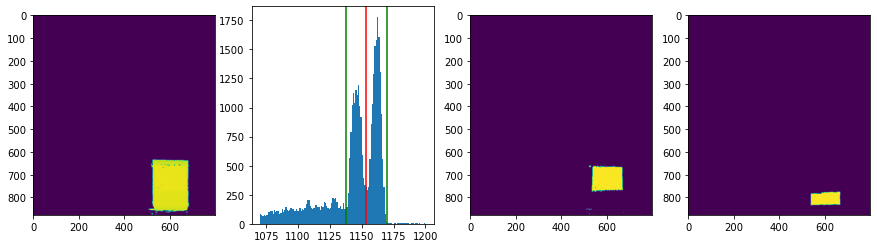

mc 006 0.09532108185712673


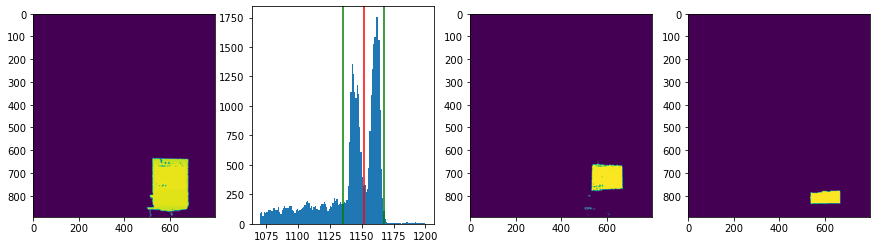

mc 007 0.09504689261961743


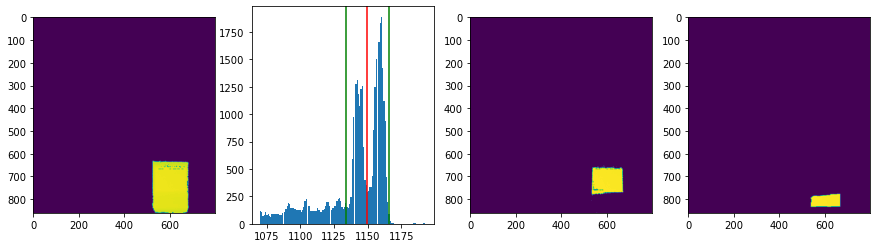

mc 008 0.09009145061921231


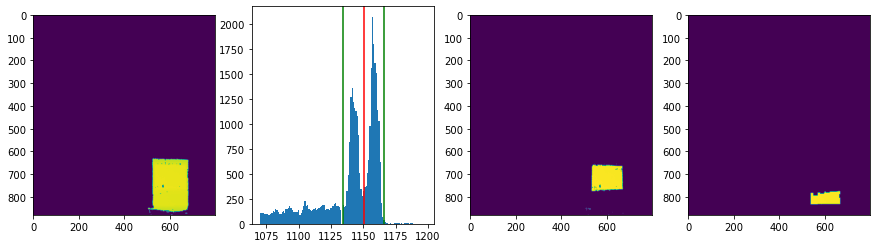

mc 009 0.09406227974023751


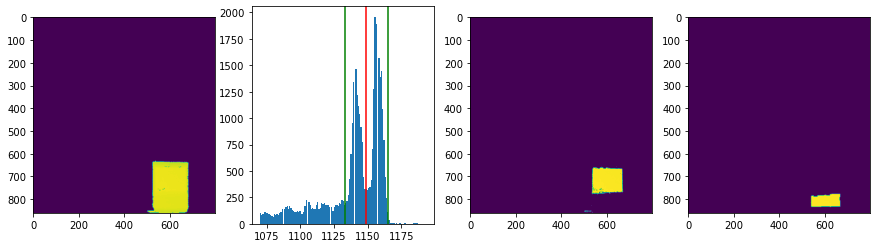

mc 010 0.09456381879775108


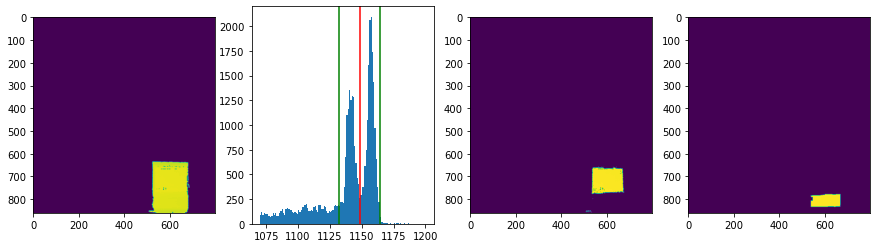

mc 011 0.09305884221838369


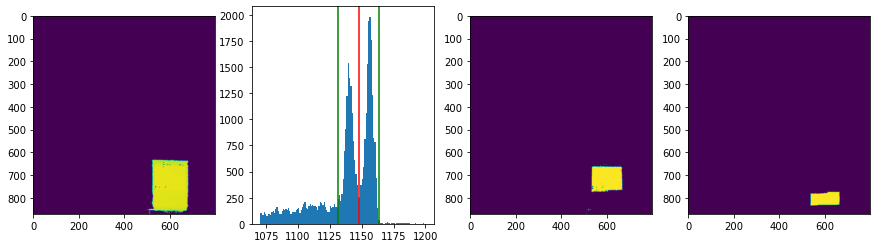

mc 013 0.0923491400620776


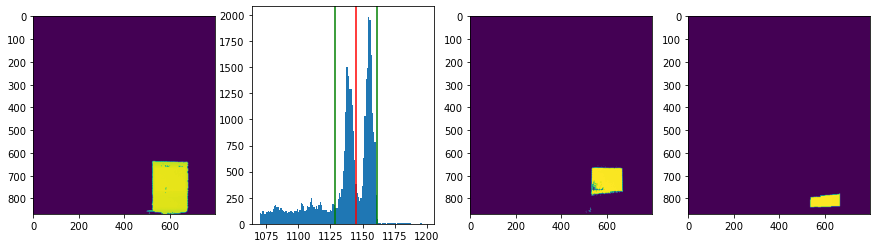

mc 014 0.0906393573582568


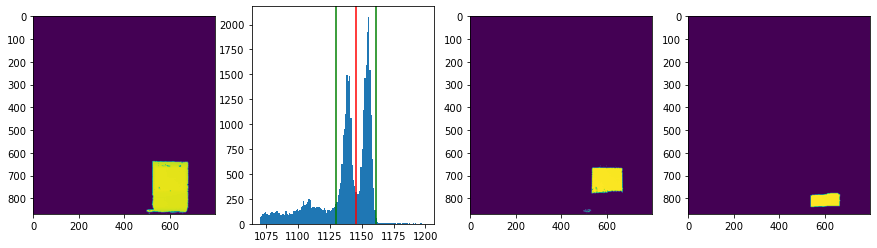

mc 015 0.09035813424193861


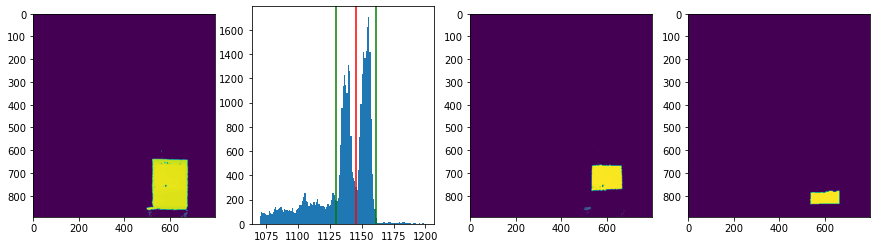

mc 016 0.09227571934313915


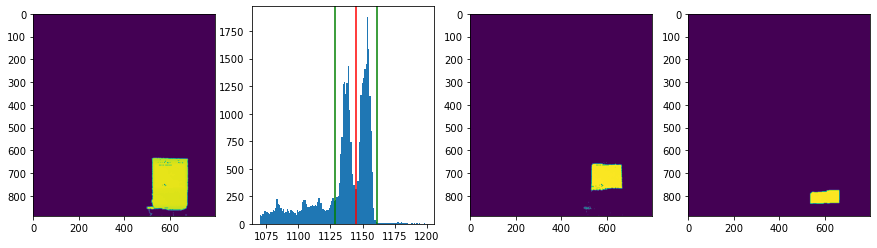

mc 017 0.09122716016869617


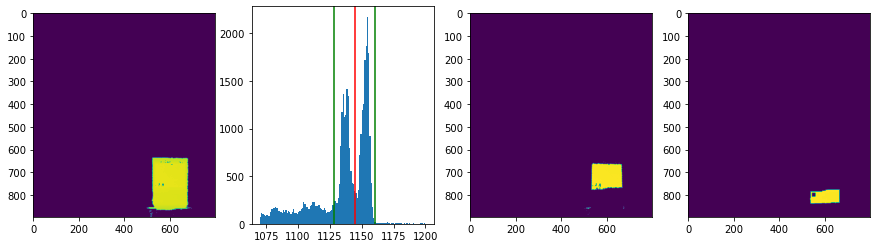

mc 018 0.09191284715705138


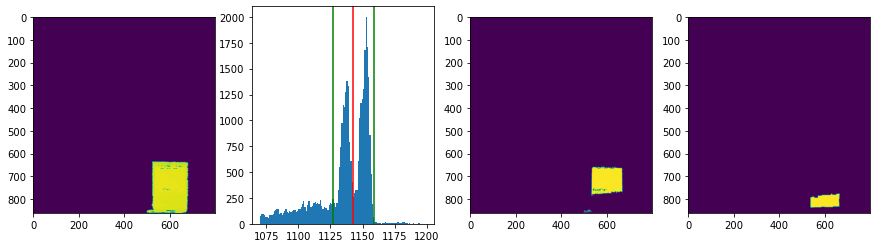

mc 019 0.0914191152536921


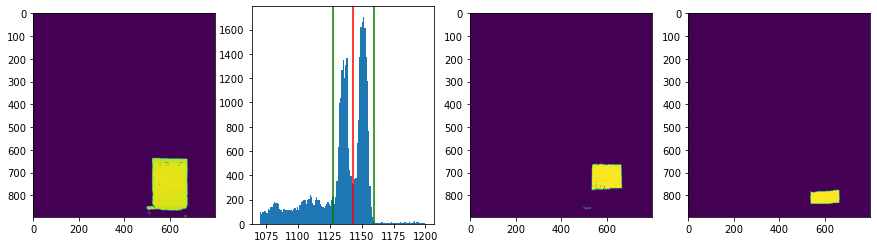

mc 020 0.09062553620976133


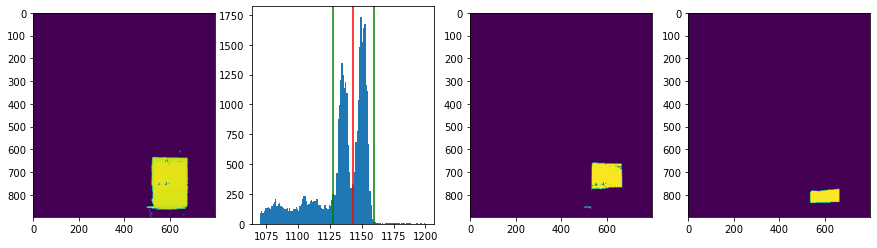

mc 021 0.09165761743886719


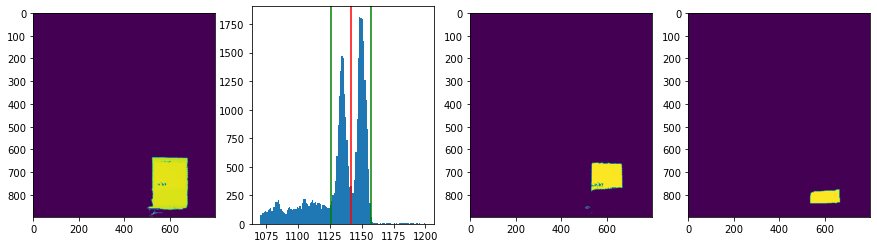

mc 022 0.0931372587105011


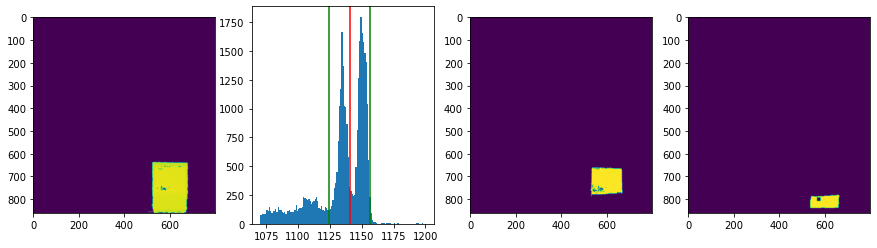

mc 023 0.09392778664242428


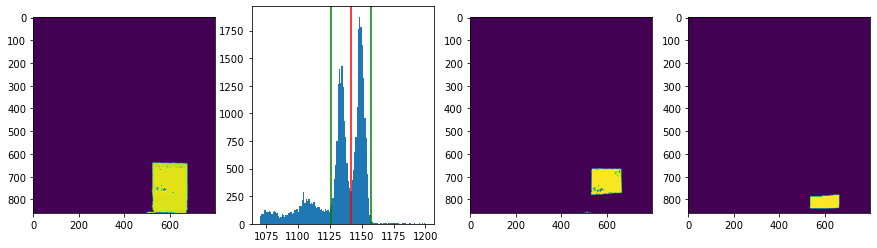

mc 024 0.0915735513347181


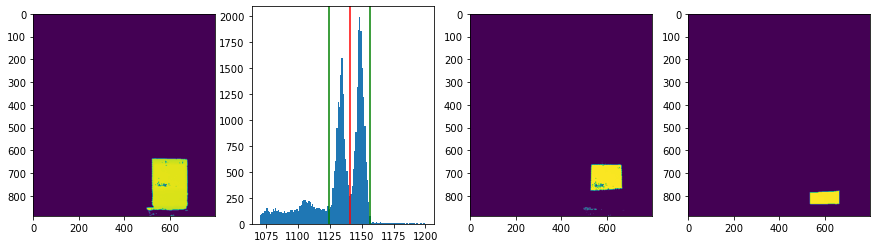

mc 025 0.09138803219819237


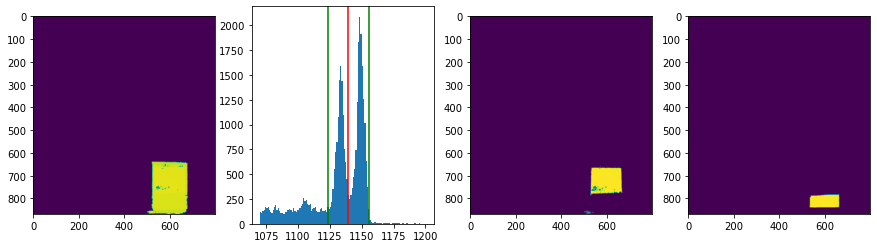

mc 026 0.09340181839245475


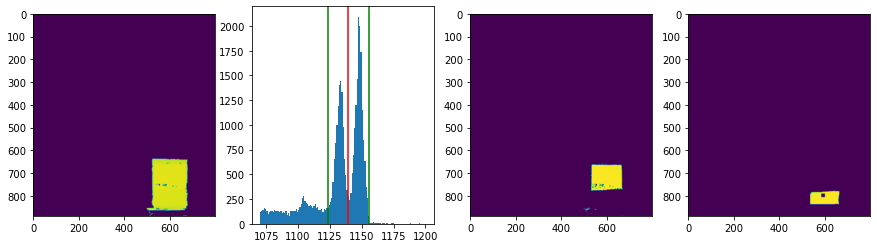

mc 027 0.09066162055367954


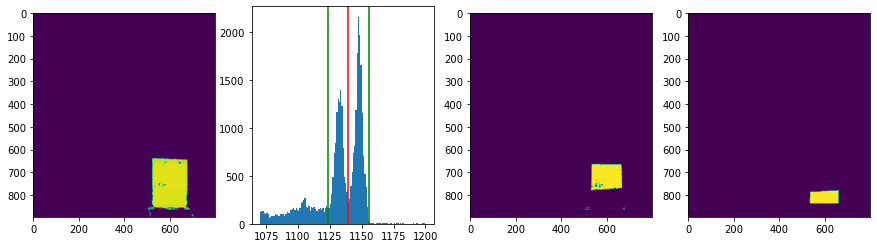

mc 028 0.09190455863865508


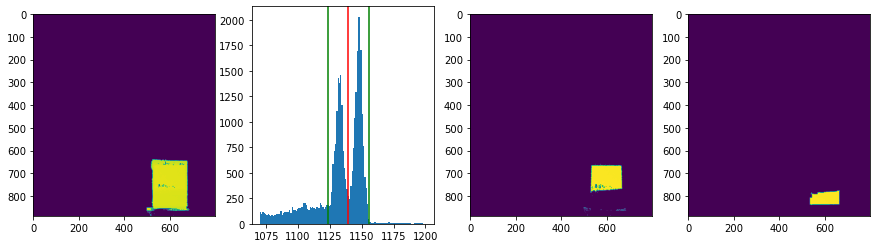

mc 029 0.09146579123415677


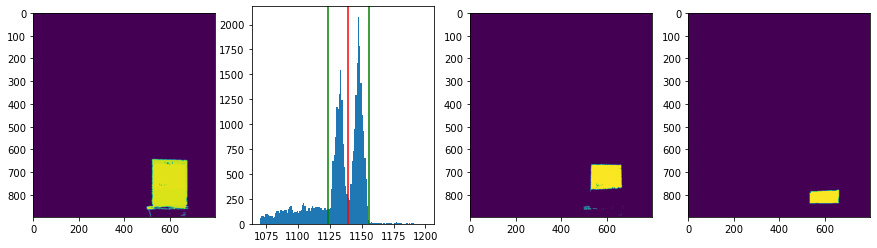

mc 030 0.0927587928039418


PermissionError: [Errno 13] Permission denied: 'D:\\Konrad\\TCM_3D\\keyence_rr\\Z-MSA.csv'

In [4]:
name, value, folder, catalog = [], [], [], []
FOLDERS = os.listdir(r'D:\Konrad\TCM_3D\keyence_rr')
for FOLDER in FOLDERS: 
    print(FOLDER)
    PATH = r'D:\Konrad\TCM_3D\keyence_rr' + '//' + FOLDER
    SUBFOLDERS = os.listdir(PATH)
    for FILE in SUBFOLDERS:
        img = cv.imread(PATH + '\\' + FILE)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        r,g,b = cv.split(img)
        z1 = fz1(1070, 1200, True)
        print(FOLDER.split('_')[6],FILE.split('_')[1].split('S')[1],z1)
        name.append(FILE.split('_')[1].split('S')[1])
        value.append(z1)
        folder.append(FOLDER.split('_')[6])
        catalog.append(FOLDER)
    data = {'operator':folder, 'name':name, 'value':value, 'folder':catalog}
    CSV_NAME = 'Z-MSA.csv'
    df = pd.DataFrame(data, columns= ['operator','name','value','folder'])  
    df.to_csv (r'D:\Konrad\TCM_3D\keyence_rr' + '\\' + CSV_NAME, sep = ',', index = False, header=True)


# Gauge block MSA 3D scan

In [ ]:
PATH = r'D:\Konrad\TCM_3D\20211102_125918_plytka_wzorcowa_skok_2mm_png'
f = os.listdir(PATH)
print(f)

In [ ]:
def fp1(A,B,C,D):
    sx,sy = r.shape
    sum1 = np.zeros(shape=[sx, sy, 1])
    sum2= np.zeros(shape=[sx, sy, 1])

    X1s,X2s,Y1s,Y2s,Z1s,Z2s = 0 ,0 ,0 ,0, 0, 0
    n1, n2 = 0,0
    for x in range(sx):
        for y in range(sy):

            if( r[x,y]==255 or (b[x,y])==0 and g[x,y]==0):
                sum1[x,y] = (int)(r[x,y]) + (int)(g[x,y]) + (int)(b[x,y])
                sum2[x,y] = (int)(r[x,y]) + (int)(g[x,y]) + (int)(b[x,y])
            else:
                sum1[x,y] = 6*255 - r[x,y] - g[x,y] - b[x,y]
                sum2[x,y] = 6*255 - r[x,y] - g[x,y] - b[x,y]
               
            if(sum1[x,y]<A or sum1[x,y]>B):sum1[x,y] = 0

            if(sum2[x,y]<C or sum2[x,y]>D):sum2[x,y] = 0

    kernel = np.ones((13, 13), np.uint8)
    sum1 = cv.erode(sum1, kernel)     
    kernel = np.ones((13, 13), np.uint8)
    sum2 = cv.erode(sum2, kernel)  

    for x in range(sx):
        for y in range(sy):
            if(sum1[x,y] != 0):
                Z1s+= sum1[x,y]
                X1s+=x
                Y1s+=y
                n1+=1
            if(sum2[x,y] != 0):
                Z2s+= sum2[x,y]  
                X2s+=x
                Y2s+=y
                n2+=1

    X1s /= n1
    X2s /= n2
    Y1s /= n1
    Y2s /= n2
    Z1s /= n1
    Z2s /= n2

    his1 = sum1[sum1 != 0]  
    his2 = sum2[sum2 != 0]        
    mean = np.mean(his1)
    mean2 = np.mean(his2)

    '''TCM_scan
    print("Means x",X1s,X2s)
    print("Means y",Y1s,Y2s)
    print("Means z",Z1s,Z2s)
    
    figure(figsize=(5, 5), dpi=80)
    plt.imshow(sum1)
    plt.show()
    figure(figsize=(5, 5), dpi=80)
    plt.imshow(sum2)
    plt.show()
    '''
     
    A1, B1, A2, B2 = [], [], [], []
    points = []
    for x in range(sx):
        for y in range(sy):
                if(sum1[x,y]>A and sum1[x,y]<B):
                    sum1[x,y] = sum1[x,y] - mean
                    A1.append([x,y,1])
                    B1.append(sum1[x,y])
                    sum1[x,y] *= 100
                if(sum2[x,y]>C and sum2[x,y]<D):
                    sum2[x,y] = sum2[x,y] - mean2
                    A2.append([x,y,1])
                    B2.append(sum2[x,y])
                    sum2[x,y] *= 100
                
    N1 = ((np.linalg.lstsq(A1,B1,rcond=None))[0])
    N2 = ((np.linalg.lstsq(A2,B2,rcond=None))[0])
    N1[2]=-1
    N2[2]=-1
    N1 = N1/np.linalg.norm(N1)
    N2 = N2/np.linalg.norm(N2)
    N = N1 + N2
    N = N/np.linalg.norm(N)
    h = abs ( N[0]*(X1s - X2s) + N[1]*(Y1s-Y2s) + N[2]*(Z1s-Z2s) )
    
    print('N1', (np.linalg.lstsq(A1,B1,rcond=None))[0])
    print('N2', (np.linalg.lstsq(A2,B2,rcond=None))[0])
    print('N', N)
    
    figure(figsize=(5, 5), dpi=80)
    plt.imshow(sum1)
    plt.show()
    figure(figsize=(5, 5), dpi=80)
    plt.imshow(sum2)
    plt.show()
    

    print(h*0.005)
    return f


for DATA in f:
    img = cv.imread(PATH + '\\' + DATA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    r,g,b = cv.split(img)
    dif=fp1(740,830,1140,1220)

